In [1]:
from dataset import *
from torch_model import *
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters.
seed = 0
batch_size = 16
num_slots = 6
num_iterations = 3
resolution = (128, 128)

In [3]:
resolution = (128, 128)
model = SlotAttentionAutoEncoder(resolution, num_slots, num_iterations, 64)
model.load_state_dict(torch.load('./checkpoint/multidsprite-k6h64-tf-od-norm/checkpoint-330.ckpt')['model_state_dict'])

<All keys matched successfully>

In [4]:
test_set = MultiDSprites('test')
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
model = model.to(device)
images = next(iter(test_loader))['image'].to(device)
recon_combineds, recons, masks, slots = model(images)
renormalize = lambda x: x / 2. + 0.5
images = renormalize(images)
recon_combineds = renormalize(recon_combineds)
recons = renormalize(recons)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 2082, 1042])


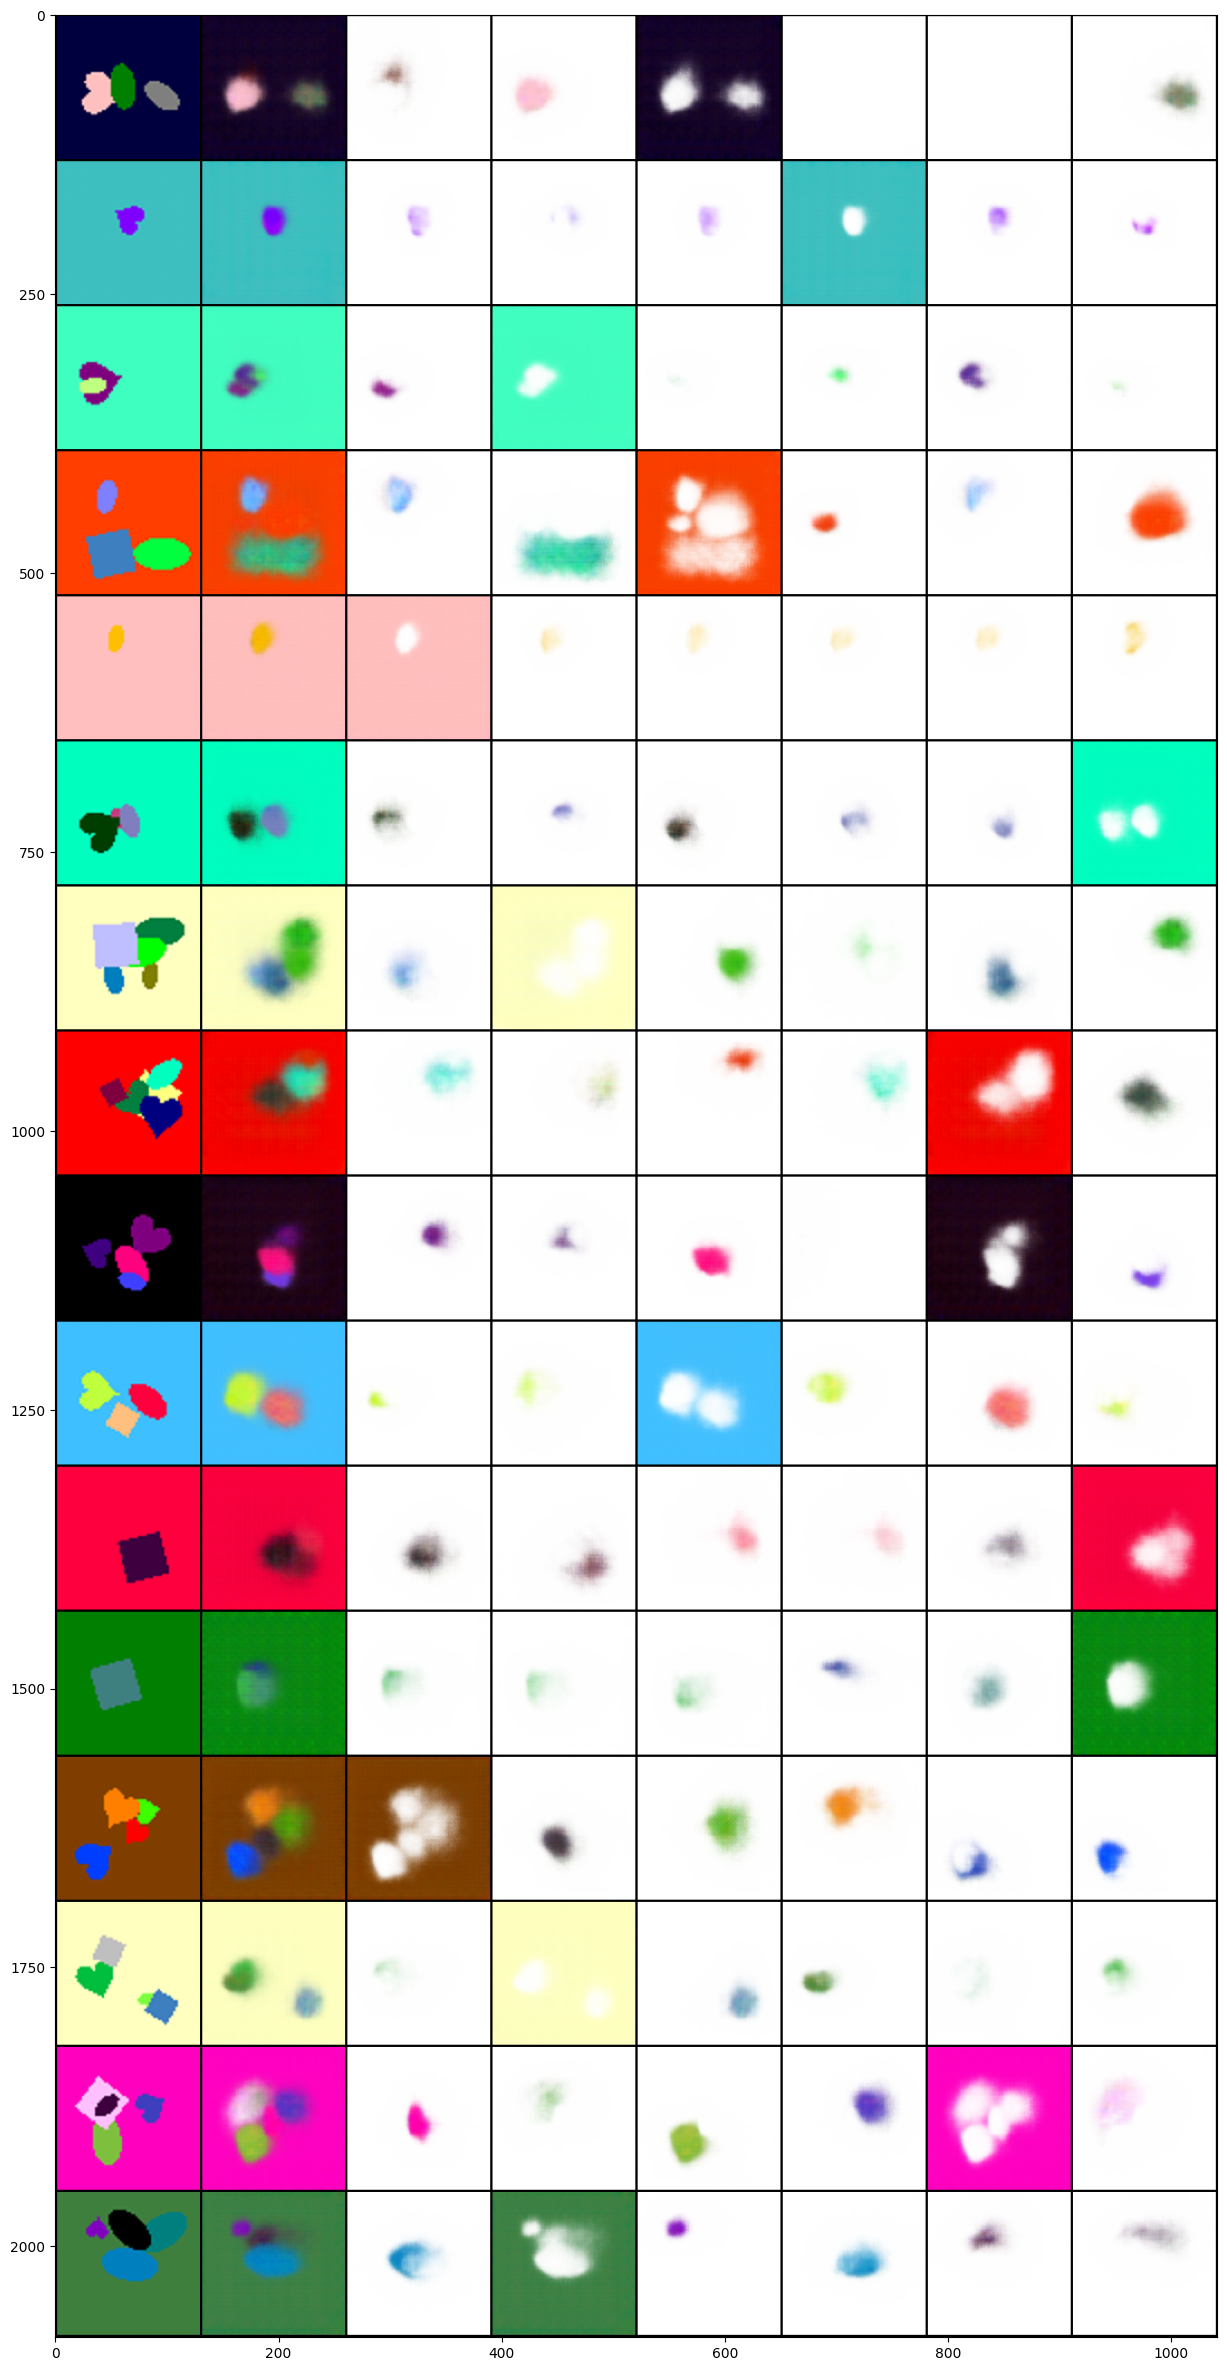

In [6]:
images_to_show = []
for i, image in enumerate(images):
    image = image.cpu()
    recon_combined = recon_combineds[i].cpu().detach()
    recon = recons[i].permute(0,3,1,2).cpu().detach()
    mask = masks[i].permute(0,3,1,2).cpu().detach()

    images_to_show.append(image)
    images_to_show.append(recon_combined)
    
    for j in range(num_slots):
        picture = recon[j] * mask[j] + (1 - mask[j])
        images_to_show.append(picture)

images_to_show = torchvision.utils.make_grid(images_to_show, nrow=num_slots+2)
print(images_to_show.shape)

plt.figure(figsize=(15,2*batch_size))
plt.imshow(images_to_show.permute(1,2,0))
#plt.savefig(os.path.join(args.image_dir, 'reconstructions_{}.png'.format(epoch)))

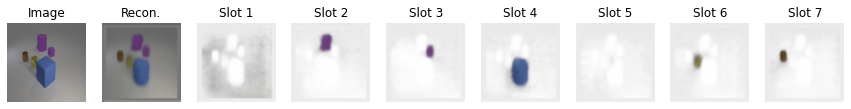

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
image = image.squeeze(0)
recon_combined = recon_combined.squeeze(0)
recons = recons.squeeze(0)
masks = masks.squeeze(0)
image = image.permute(1,2,0).cpu().numpy()
recon_combined = recon_combined.permute(1,2,0)
recon_combined = recon_combined.cpu().detach().numpy()
recons = recons.cpu().detach().numpy()
masks = masks.cpu().detach().numpy()
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
for i in range(7):
  picture = recons[i] * masks[i] + (1 - masks[i])
  ax[i + 2].imshow(picture)
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')